# Análisis de la base de datos "Censo Poblacional Agosto"

Realizado por:

*   Laura Daniela Rojas Ardila
*   Stiven Alexis Villamizar Buitrago


## Objetivo del análisis

Analizar las condiciones de vida y los niveles de pobreza de los hogares del municipio Los Santos (Santander), utilizando la información del Censo y la clasificación SISBÉN. Se usaron indicadores compuestos de vivienda, bienes del hogar, ingresos y gastos, además de técnicas de agrupamiento (clustering) y análisis estadístico para caracterizar y segmentar a la población.

## Importe de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

## Importe de datos

In [3]:
df = pd.read_excel("/content/CENSOPOBLACIONALAGOSTO.xlsx")

columnas_relevantes = [
    'tip_vivienda', 'tip_mat_paredes', 'tip_mat_pisos', 'num_cuartos_vivienda', 'num_hogares_vivienda',
    'tip_estrato_energia', 'ind_tiene_energia', 'ind_tiene_acueducto', 'ind_tiene_alcantarillado',
    'ind_tiene_gas', 'ind_tiene_recoleccion', 'ind_tiene_nevera', 'ind_tiene_lavadora', 'ind_tiene_pc',
    'ind_tiene_internet', 'ind_tiene_moto', 'ind_tiene_carro', 'tip_sanitario', 'tip_uso_sanitario',
    'tip_origen_agua', 'ind_agua_llega_7dias', 'vlr_gasto_alimento', 'vlr_gasto_educacion',
    'vlr_gasto_salud', 'vlr_gasto_arriendo', 'ind_ingr_salario', 'vlr_ingr_salario',
    'ind_ingr_pension', 'vlr_ingr_pension', 'ind_ingr_remesa_exterior', 'vlr_ingr_remesa_exterior',
    'ind_estudia', 'niv_educativo', 'tip_actividad_mes', 'ind_discap_ver', 'ind_discap_oir',
    'ind_evento_inundacion', 'num_personas_hogar', 'I15', 'Grupo', 'Nivel', 'Clasificacion'
]

df_filtrado = df[columnas_relevantes].copy()

## Imputación y limpieza de los datos

In [4]:
gasto_cols = ['vlr_gasto_alimento', 'vlr_gasto_educacion', 'vlr_gasto_salud', 'vlr_gasto_arriendo']
ingreso_cols = ['vlr_ingr_salario', 'vlr_ingr_pension', 'vlr_ingr_remesa_exterior']

for col in gasto_cols + ingreso_cols:
    df_filtrado[col] = df_filtrado.groupby('Grupo')[col].transform(lambda x: x.fillna(x.mean()))

binary_cols = ['ind_tiene_energia', 'ind_tiene_acueducto', 'ind_tiene_alcantarillado',
               'ind_tiene_gas', 'ind_tiene_recoleccion', 'ind_tiene_nevera',
               'ind_tiene_lavadora', 'ind_tiene_pc', 'ind_tiene_internet']
for col in binary_cols:
    df_filtrado[col] = df_filtrado[col].fillna(df_filtrado[col].mode()[0])

## Transformación de datos

In [5]:
def treat_outliers_std(df, cols, n_std=3):
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = df[col].clip(mean - n_std*std, mean + n_std*std)
    return df

numeric_cols = df_filtrado.select_dtypes(include=['float64', 'int64']).columns
df_filtrado = treat_outliers_std(df_filtrado, numeric_cols)

money_cols = gasto_cols + ingreso_cols
for col in money_cols:
    df_filtrado[col] = np.log1p(df_filtrado[col])

## Indicadores compuestos

In [6]:
map_paredes = {1: 3, 2: 2}
df_filtrado['pared_score'] = df_filtrado['tip_mat_paredes'].map(map_paredes).fillna(1)
map_pisos = {1: 3, 2: 2, 3: 1, 4: 1, 5: 0, 6: 1}
df_filtrado['piso_score'] = df_filtrado['tip_mat_pisos'].map(map_pisos).fillna(0)
df_filtrado['servicios_score'] = df_filtrado[['ind_tiene_energia', 'ind_tiene_acueducto', 'ind_tiene_alcantarillado']].sum(axis=1)
df_filtrado['ICV'] = df_filtrado['pared_score'] + df_filtrado['piso_score'] + df_filtrado['servicios_score']

df_filtrado['IBH'] = df_filtrado[['ind_tiene_nevera', 'ind_tiene_lavadora', 'ind_tiene_pc', 'ind_tiene_internet']].sum(axis=1)
df_filtrado['total_gastos'] = df_filtrado[gasto_cols].sum(axis=1)
df_filtrado['total_ingresos'] = df_filtrado[ingreso_cols].sum(axis=1) + 0.01
df_filtrado['ratio_gi'] = df_filtrado['total_gastos'] / df_filtrado['total_ingresos']

## Indicadores Construidos

ICV (Indicador de Calidad de Vivienda): Evalúa paredes, pisos y servicios públicos.

IBH (Indicador de Bienes del Hogar): Evalúa presencia de nevera, lavadora, computador e internet.

Ratio G/I: Relación entre gastos totales e ingresos totales.

Número de personas por hogar, ingresos y gastos como apoyo contextual.

## Agrupación SISBEN

In [7]:
df_filtrado['Grupo_SISBEN'] = df_filtrado['Clasificacion'].astype(str).str.strip().str.upper().str[0]

## Estadísticas descriptivas y ANOVA

In [8]:
variables = ['ICV', 'IBH', 'ratio_gi', 'num_personas_hogar', 'total_gastos', 'total_ingresos']
describe_global = df_filtrado[variables].describe().round(2)
print("\nEstadísticas globales:")
print(describe_global)

stats = df_filtrado.groupby('Grupo_SISBEN')[variables].agg(['mean', 'std', 'median', 'min', 'max']).round(2)
print("\nEstadísticas por grupo SISBEN:")
print(stats)

print("\nResultados ANOVA:")
for var in variables:
    grupos = [grupo[var].dropna() for _, grupo in df_filtrado.groupby('Grupo_SISBEN')]
    if len(grupos) > 1:
        f, p = f_oneway(*grupos)
        print(f"{var}: F = {f:.2f}, p = {p:.4f} {'**' if p < 0.05 else ''}")


Estadísticas globales:
            ICV       IBH  ratio_gi  num_personas_hogar  total_gastos  \
count  12987.00  12987.00  12987.00            12987.00      12987.00   
mean       8.48      7.35   1962.41                3.59         22.21   
std        1.08      0.62   1129.45                1.42          9.27   
min        5.00      5.38      0.00                1.00          0.00   
25%        8.00      7.00   1220.61                3.00         12.61   
50%        9.00      7.00   2320.82                4.00         23.84   
75%        9.00      8.00   2481.76                4.00         25.04   
max       10.54      8.00   5003.94                7.92         50.04   

       total_ingresos  
count        12987.00  
mean             1.43  
std              3.95  
min              0.01  
25%              0.01  
50%              0.01  
75%              0.01  
max             25.94  

Estadísticas por grupo SISBEN:
               ICV                            IBH                     

## Interpretación de los resultados obtenidos para las estadísticas descriptivas

*   Todos los grupos presentan altos niveles de calidad de vivienda (ICV ~8.3 a 8.6).
*   Grupo A tiene los ingresos más bajos (prom. 0.36), lo cual es coherente con su clasificación.
*   Los IBH también son altos, lo que sugiere buen acceso a bienes esenciales.
*   El ratio G/I es muy elevado, indicando que los hogares gastan mucho en proporción a lo que declaran como ingresos.


## Interpretación de los resultados obtenidos para el ANOVA

Se encontró que las diferencias entre grupos SISBÉN no son significativas en la mayoría de los indicadores. Esto puede deberse a:



*   Homogeneidad de condiciones materiales entre hogares del municipio.
*   Baja sensibilidad de los grupos a los indicadores utilizados.
*   Clasificación SISBÉN basada en más dimensiones no incluidas (educación, salud, vulnerabilidad, etc.).


## Calculo de correlaciones

In [9]:
corr = df_filtrado[variables].corr().round(2)
print("\nCorrelación general:")
print(corr)

for grupo in df_filtrado['Grupo_SISBEN'].unique():
    sub = df_filtrado[df_filtrado['Grupo_SISBEN'] == grupo]
    print(f"\nCorrelación en grupo {grupo}:")
    print(sub[variables].corr().round(2))


Correlación general:
                     ICV   IBH  ratio_gi  num_personas_hogar  total_gastos  \
ICV                 1.00 -0.19      0.15                0.06          0.18   
IBH                -0.19  1.00     -0.16               -0.22         -0.20   
ratio_gi            0.15 -0.16      1.00                0.18          0.73   
num_personas_hogar  0.06 -0.22      0.18                1.00          0.20   
total_gastos        0.18 -0.20      0.73                0.20          1.00   
total_ingresos     -0.02  0.02     -0.62               -0.05          0.01   

                    total_ingresos  
ICV                          -0.02  
IBH                           0.02  
ratio_gi                     -0.62  
num_personas_hogar           -0.05  
total_gastos                  0.01  
total_ingresos                1.00  

Correlación en grupo A:
                     ICV   IBH  ratio_gi  num_personas_hogar  total_gastos  \
ICV                 1.00 -0.19      0.22                0.08         

## Interpretación de los resultados de las correlaciones

*   Ratio G/I tiene fuerte correlación positiva con gastos (0.73) y fuerte correlación negativa con ingresos (-0.62).
*   IBH y ICV están débilmente correlacionados (-0.19), lo que sugiere que calidad de vivienda y bienes del hogar no siempre van de la mano.

Esto muestra que a mayor ingreso, el ratio G/I baja, y que los hogares con más gastos tienden a tener ratios mucho más altos.

## Gráficos

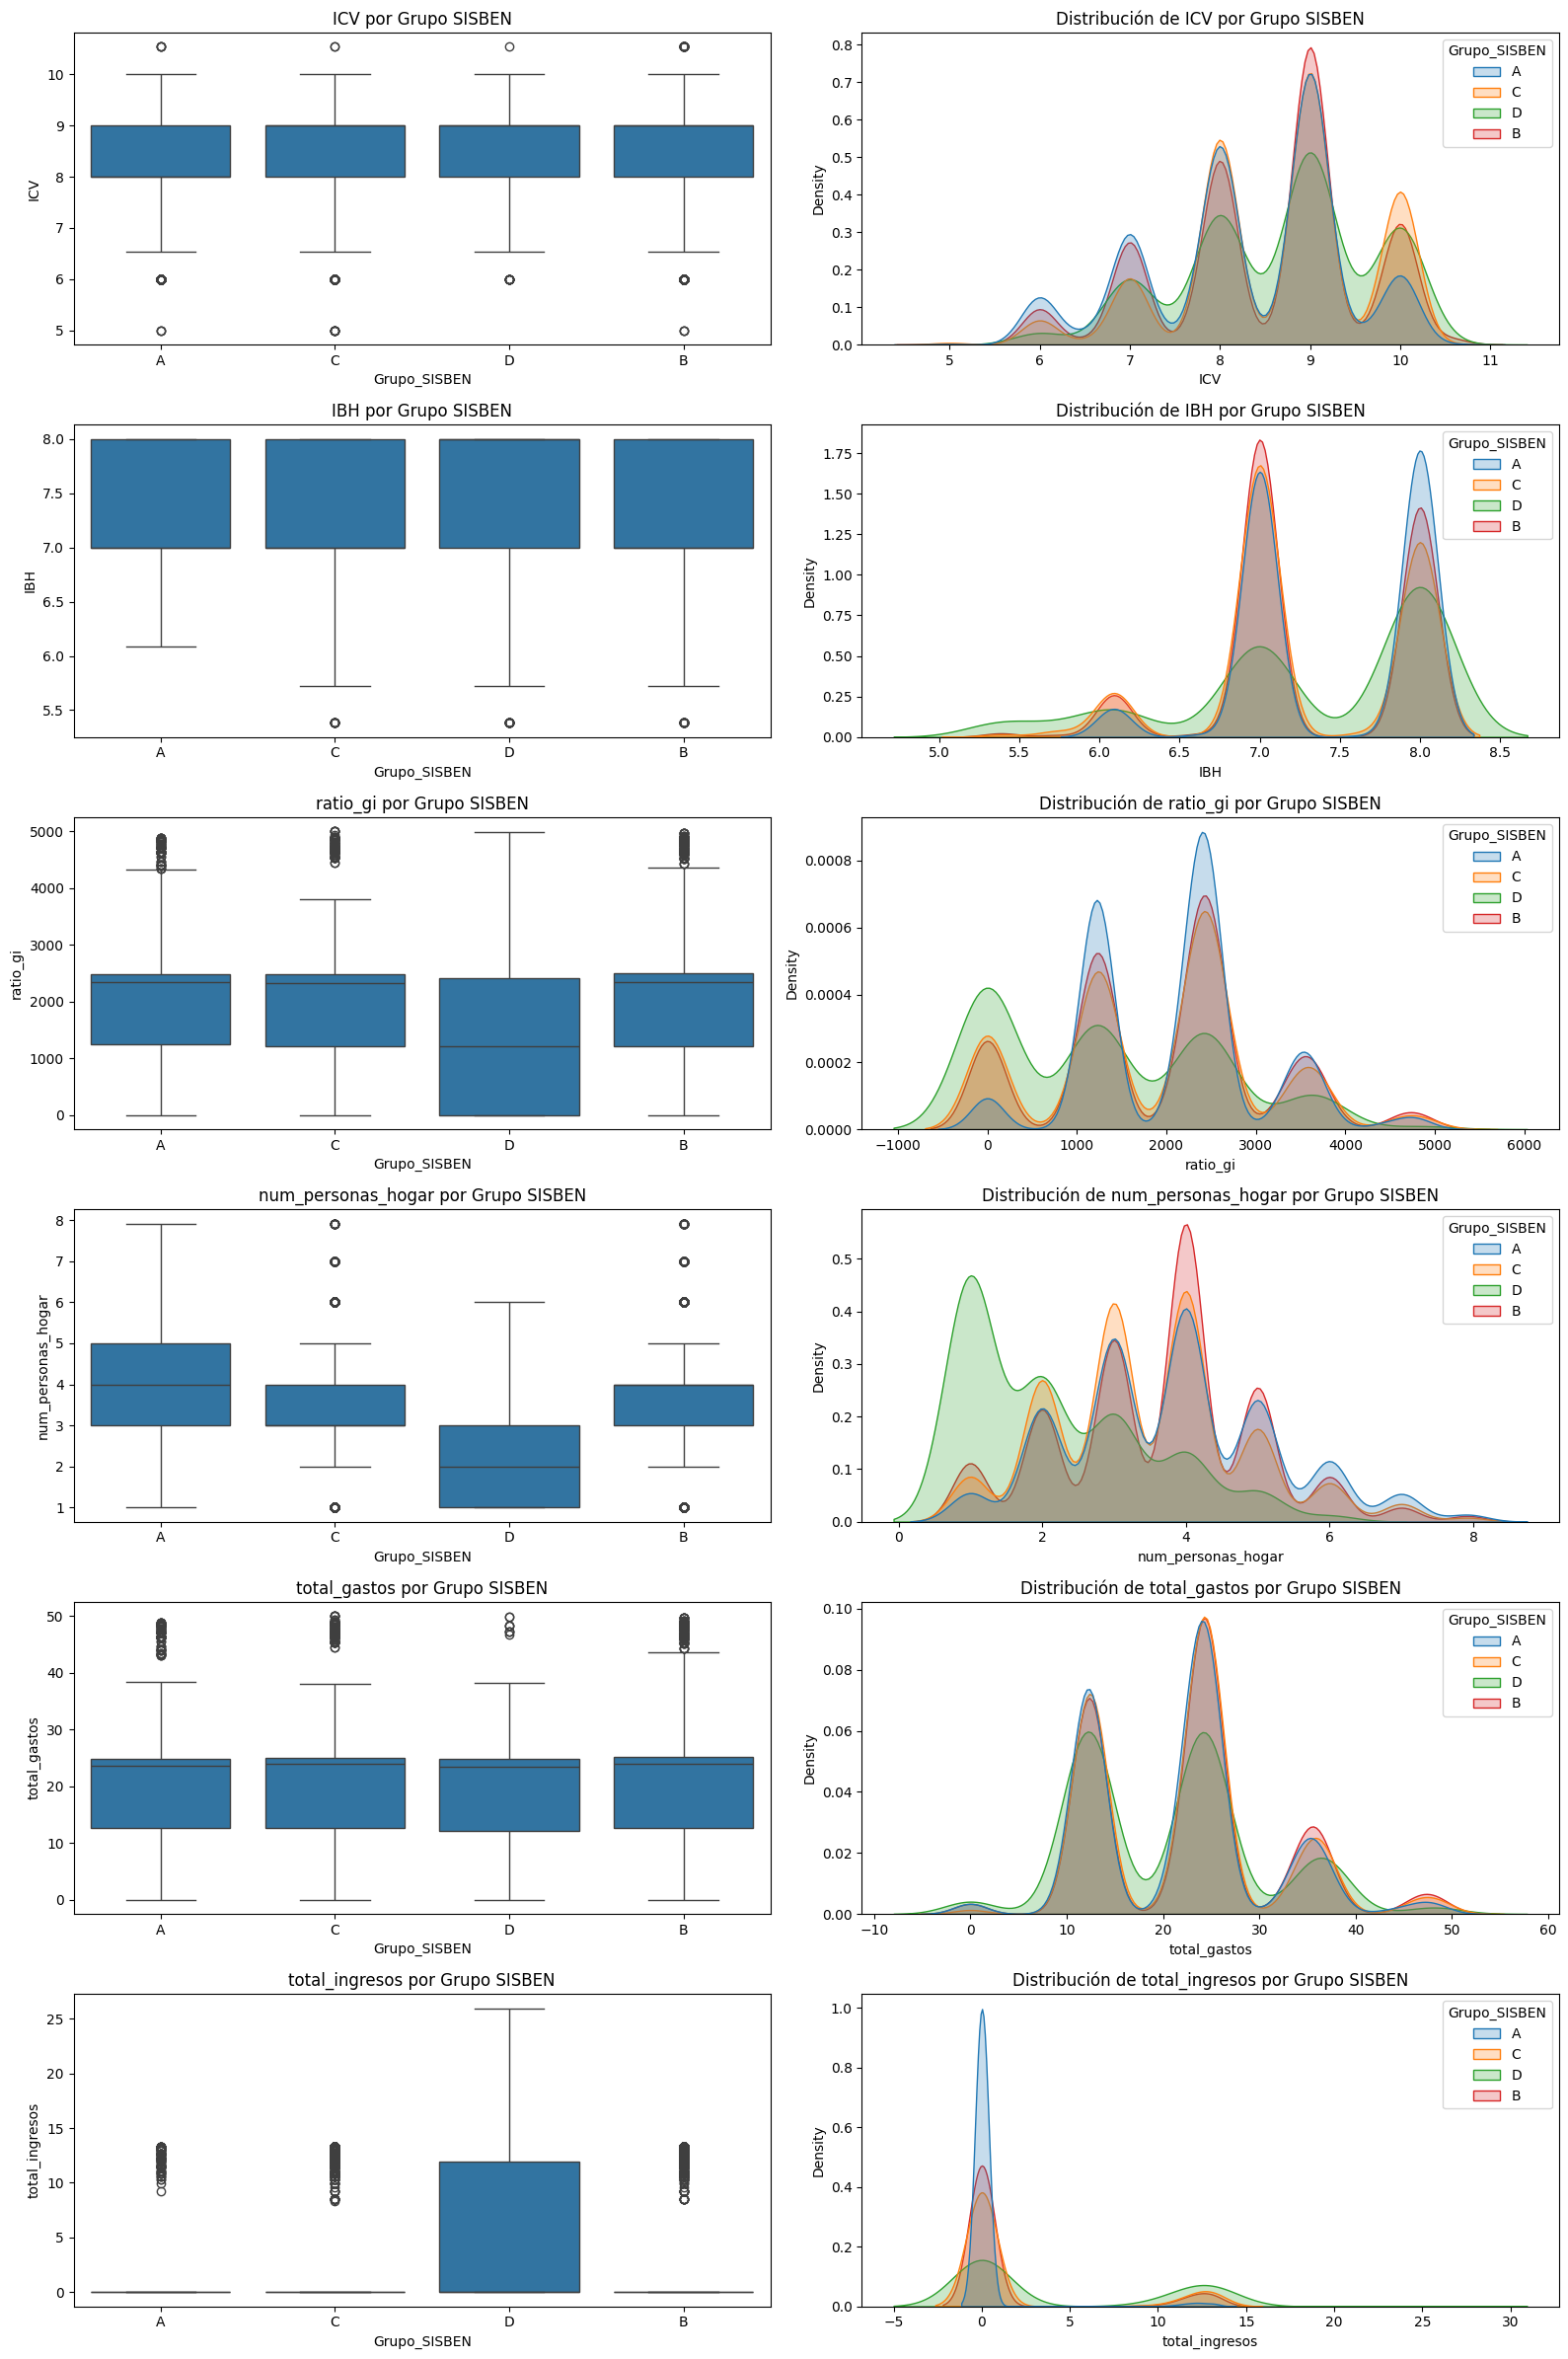

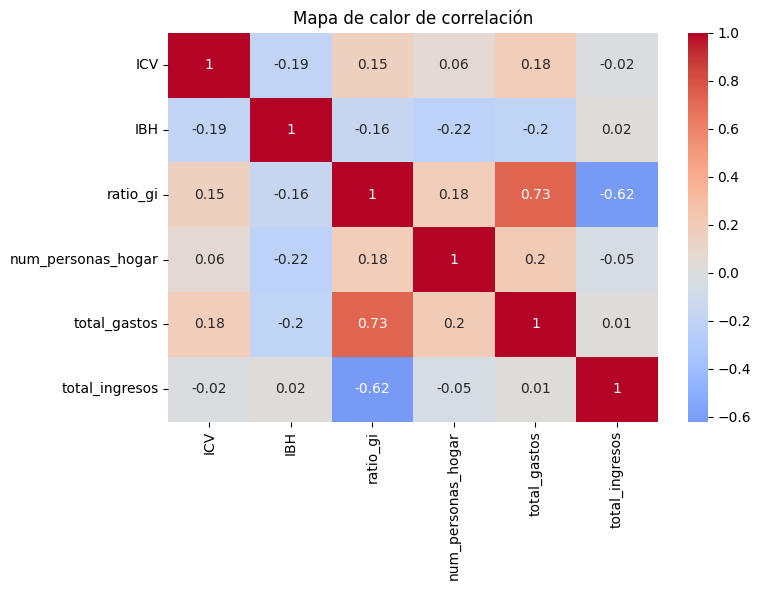

In [10]:
plt.figure(figsize=(16, 4 * len(variables)))
for i, var in enumerate(variables):
    plt.subplot(len(variables), 2, 2*i + 1)
    sns.boxplot(x='Grupo_SISBEN', y=var, data=df_filtrado)
    plt.title(f'{var} por Grupo SISBEN')
    plt.savefig(f"boxplot_{var}.png", dpi=300)

    plt.subplot(len(variables), 2, 2*i + 2)
    sns.kdeplot(data=df_filtrado, x=var, hue='Grupo_SISBEN', fill=True, common_norm=False)
    plt.title(f'Distribución de {var} por Grupo SISBEN')
    plt.savefig(f"kde_{var}.png", dpi=300)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Mapa de calor de correlación")
plt.tight_layout()
plt.savefig("correlacion_heatmap.png", dpi=300)
plt.show()

## Distribución

In [11]:
print("\nDistribución de tipo de vivienda por Grupo SISBEN:")
print(pd.crosstab(df_filtrado['Grupo_SISBEN'], df_filtrado['tip_vivienda'], normalize='index').round(2))


Distribución de tipo de vivienda por Grupo SISBEN:
tip_vivienda  1.000000  2.000000  3.000000  4.000000  4.085753
Grupo_SISBEN                                                  
A                 0.66      0.00      0.34       0.0       0.0
B                 0.79      0.00      0.21       0.0       0.0
C                 0.81      0.00      0.19       0.0       0.0
D                 0.77      0.01      0.22       0.0       0.0


## Clustering


Perfil por cluster:
          ICV         IBH       ratio_gi         num_personas_hogar        \
         mean   std  mean   std     mean     std               mean   std   
cluster                                                                     
0.0      9.18  0.76  6.93  0.49  2998.37  778.78               3.94  0.96   
1.0      8.18  1.07  8.00  0.02  1610.04  952.60               2.66  1.04   
2.0      8.25  1.05  6.88  0.33  1166.73  848.40               3.12  1.01   
3.0      8.11  1.01  7.41  0.57  1907.68  944.24               5.75  0.87   

        total_gastos       total_ingresos        
                mean   std           mean   std  
cluster                                          
0.0            29.98  7.79           0.01  0.00  
1.0            19.00  7.61           1.68  4.18  
2.0            17.57  7.75           3.15  5.45  
3.0            21.01  7.77           1.07  3.45  


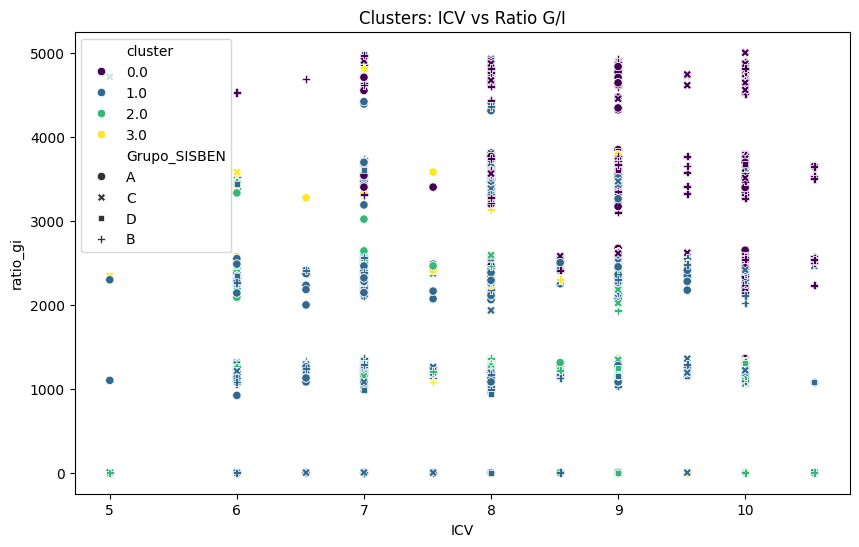

In [12]:
cluster_vars = ['ICV', 'IBH', 'ratio_gi', 'num_personas_hogar']
X = df_filtrado[cluster_vars].dropna()
X_scaled = (X - X.mean()) / X.std()
kmeans = KMeans(n_clusters=4, random_state=42)
df_filtrado.loc[X.index, 'cluster'] = kmeans.fit_predict(X_scaled)

perfil_cluster = df_filtrado.groupby('cluster')[variables].agg(['mean', 'std']).round(2)
print("\nPerfil por cluster:")
print(perfil_cluster)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtrado.dropna(subset=['cluster']),
                x='ICV', y='ratio_gi', hue='cluster', style='Grupo_SISBEN', palette='viridis')
plt.title('Clusters: ICV vs Ratio G/I')
plt.savefig("clusters_icv_ratio.png", dpi=300)
plt.show()

## Interpretación de los resultados obtenidos para el clustering

*   Cluster 0 representa hogares con excelente vivienda (ICV alto), pero sin ingresos registrados y gastos elevados.
*   Cluster 2 tiene los ingresos más altos y gastos moderados → posible perfil de mejor situación económica real.
*   Cluster 1 presenta el mayor IBH (más bienes), pero ingresos y gastos más equilibrados.
*   Esto revela que los grupos SISBEN no capturan bien estas diferencias, mientras que el clustering sí permite segmentaciones más útiles.


## Exportar resultados

In [13]:
df_filtrado.to_csv("resultados_pobreza_los_santos.csv", index=False)
stats.to_csv("estadisticas_por_grupo.csv")
perfil_cluster.to_csv("perfil_por_cluster.csv")
corr.to_csv("correlaciones.csv")

## Conclusiones

*   Los indicadores muestran condiciones materiales buenas en general: viviendas dignas, servicios completos, y acceso a bienes esenciales.
*   Sin embargo, los ingresos declarados son muy bajos, lo que provoca ratios G/I extremadamente altos (hasta >1000).
*   No hay diferencias sustanciales entre grupos SISBEN en los indicadores usados, lo cual cuestiona su sensibilidad en este contexto.
*   El clustering fue útil para identificar perfiles socioeconómicos más diversos, que podrían complementar la clasificación oficial.
